In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="")
project = rf.workspace("blueprintvision").project("blurdetection-d9o8a")
version = project.version(1)
dataset = version.download("folder")
                

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.7/86.7 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 35.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 91.3 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: idna
    Found existing installation: idna 3.10
    Uninstalling idna-3.10:
      Successfully uninstalled idna-3.10
  Attempting uninstall: opencv-python-headless
    Found existing installation: opencv-python-headless 4.11.0.86
    Uninstalling opencv-python-headless-4.11.0.86:
      Successfully uninstalled opencv-python-headless-4.11.0.86
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datasets 3.6.0 requires fsspec[http]<=2025.3.0,>=2023.1.0, but you have fsspec 2025.3.2 which is incompatible.
google-cola


Extracting Dataset Version Zip to blurdetection-1 in folder:: 100%|██████████| 4073/4073 [00:00<00:00, 7058.79it/s]


Processing blur: 100%|██████████| 185/185 [00:01<00:00, 127.08it/s]



🔹 Training RandomForest

📋 RandomForest - Validation Results:
              precision    recall  f1-score   support

       sharp       0.84      0.88      0.86       453
        blur       0.84      0.80      0.82       360

    accuracy                           0.84       813
   macro avg       0.84      0.84      0.84       813
weighted avg       0.84      0.84      0.84       813



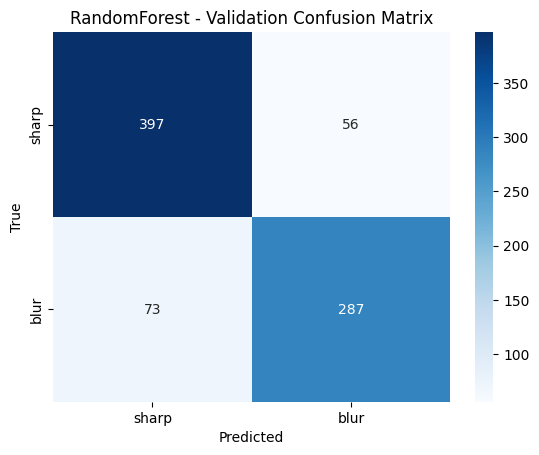


📋 RandomForest - Test Results:
              precision    recall  f1-score   support

       sharp       0.86      0.90      0.88       221
        blur       0.87      0.83      0.85       185

    accuracy                           0.86       406
   macro avg       0.87      0.86      0.86       406
weighted avg       0.86      0.86      0.86       406



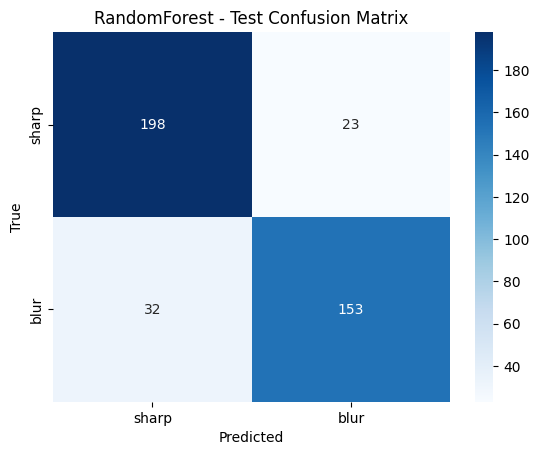

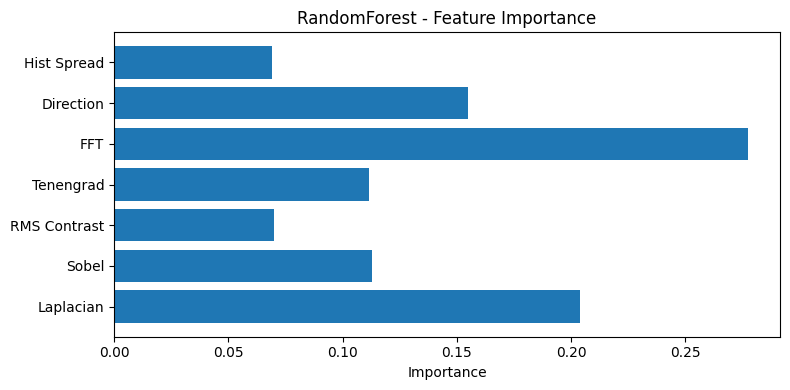


🔹 Training XGBoost

📋 XGBoost - Validation Results:
              precision    recall  f1-score   support

       sharp       0.86      0.88      0.87       453
        blur       0.84      0.81      0.83       360

    accuracy                           0.85       813
   macro avg       0.85      0.85      0.85       813
weighted avg       0.85      0.85      0.85       813



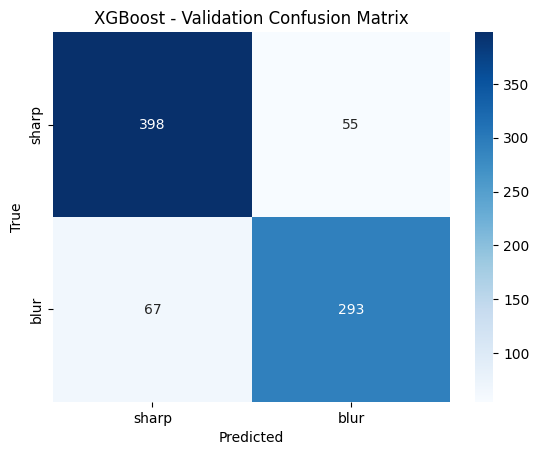


📋 XGBoost - Test Results:
              precision    recall  f1-score   support

       sharp       0.88      0.87      0.88       221
        blur       0.85      0.85      0.85       185

    accuracy                           0.86       406
   macro avg       0.86      0.86      0.86       406
weighted avg       0.86      0.86      0.86       406



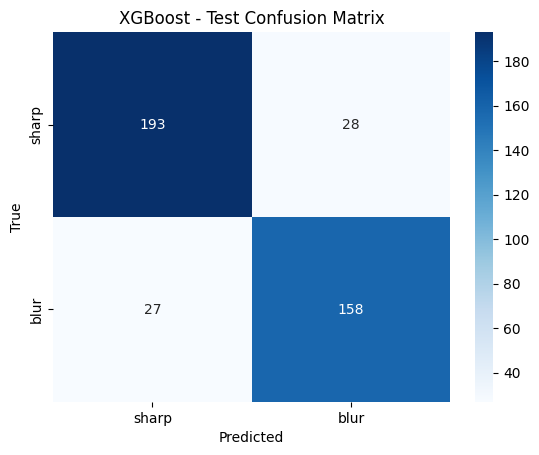

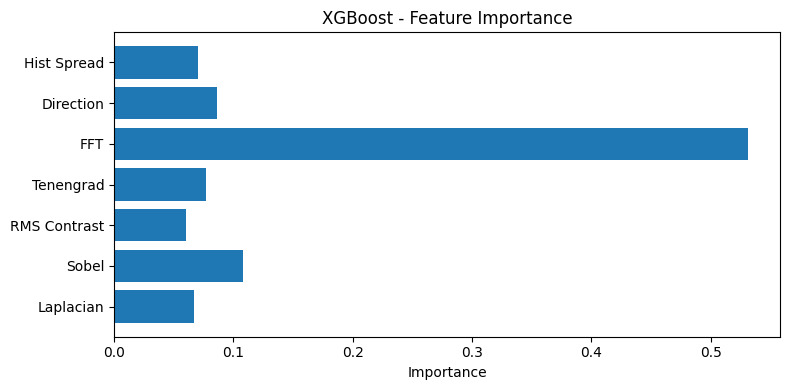


🔹 Training SVM

📋 SVM - Validation Results:
              precision    recall  f1-score   support

       sharp       0.83      0.89      0.86       453
        blur       0.85      0.77      0.81       360

    accuracy                           0.84       813
   macro avg       0.84      0.83      0.83       813
weighted avg       0.84      0.84      0.84       813



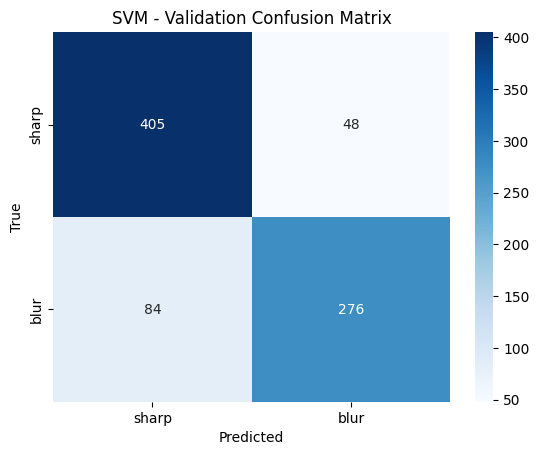


📋 SVM - Test Results:
              precision    recall  f1-score   support

       sharp       0.87      0.89      0.88       221
        blur       0.87      0.84      0.85       185

    accuracy                           0.87       406
   macro avg       0.87      0.86      0.87       406
weighted avg       0.87      0.87      0.87       406



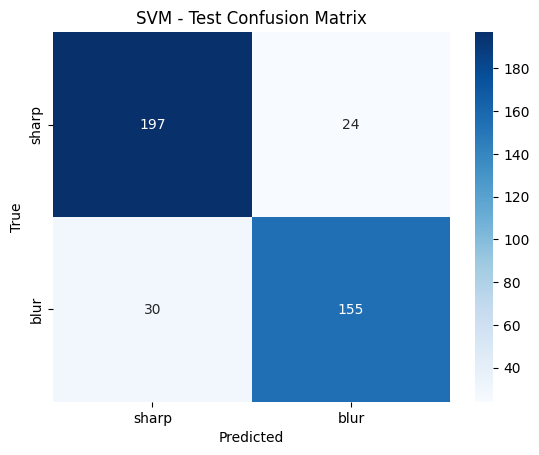


🔹 Training LogReg

📋 LogReg - Validation Results:
              precision    recall  f1-score   support

       sharp       0.83      0.87      0.85       453
        blur       0.82      0.78      0.80       360

    accuracy                           0.83       813
   macro avg       0.83      0.82      0.82       813
weighted avg       0.83      0.83      0.83       813



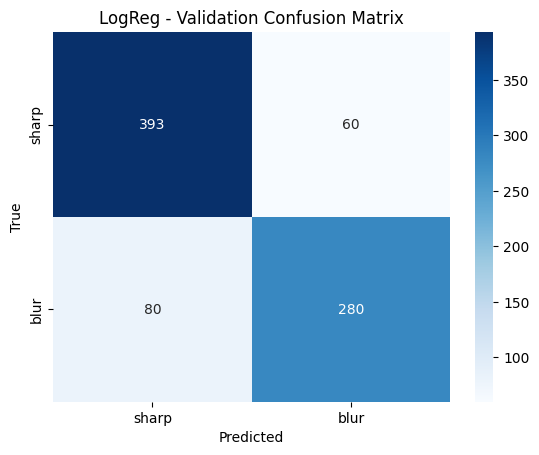


📋 LogReg - Test Results:
              precision    recall  f1-score   support

       sharp       0.87      0.87      0.87       221
        blur       0.85      0.85      0.85       185

    accuracy                           0.86       406
   macro avg       0.86      0.86      0.86       406
weighted avg       0.86      0.86      0.86       406



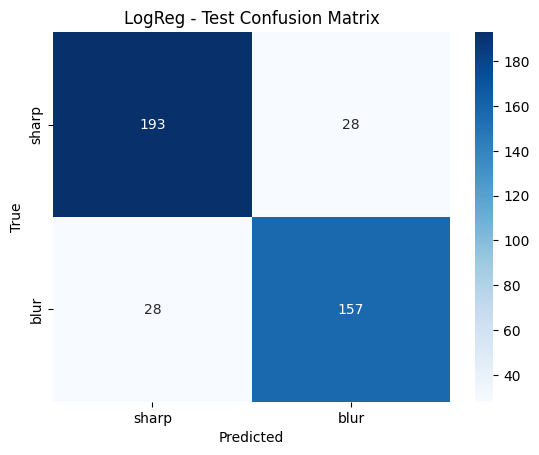

In [2]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler

def variance_of_laplacian(img):
    return cv2.Laplacian(img, cv2.CV_64F).var()

def sobel_edge(img):
    sobelx = cv2.Sobel(img, cv2.CV_64F, 1, 0)
    sobely = cv2.Sobel(img, cv2.CV_64F, 0, 1)
    return np.mean(np.sqrt(sobelx**2 + sobely**2))

def rms_contrast(img):
    return np.std(img)

def tenengrad(img):
    gx = cv2.Sobel(img, cv2.CV_64F, 1, 0)
    gy = cv2.Sobel(img, cv2.CV_64F, 0, 1)
    return np.mean(gx**2 + gy**2)

def fft_energy(img):
    f = np.fft.fft2(img)
    fshift = np.fft.fftshift(f)
    mag = np.log(np.abs(fshift) + 1)
    return np.mean(mag)

def edge_directionality(img):
    edges = cv2.Canny(img, 100, 200)
    sobelx = cv2.Sobel(edges, cv2.CV_64F, 1, 0)
    sobely = cv2.Sobel(edges, cv2.CV_64F, 0, 1)
    angle = np.arctan2(sobely, sobelx)
    return np.std(angle)

def histogram_spread(img):
    hist = cv2.calcHist([img], [0], None, [256], [0,256])
    return np.std(hist)

def extract_from_dir(directory):
    X, y = [], []
    for label_name in ['sharp', 'blur']:
        label = 0 if label_name == 'sharp' else 1
        class_path = os.path.join(directory, label_name)
        for filename in tqdm(os.listdir(class_path), desc=f"Processing {label_name}"):
            try:
                img_path = os.path.join(class_path, filename)
                img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                img = cv2.resize(img, (224, 224))

                features = [
                    variance_of_laplacian(img),
                    sobel_edge(img),
                    rms_contrast(img),
                    tenengrad(img),
                    fft_energy(img),
                    edge_directionality(img),
                    histogram_spread(img)
                ]

                X.append(features)
                y.append(label)
            except Exception as e:
                print(f"Error with {filename}: {e}")
    return np.array(X), np.array(y)

base_path = "/kaggle/working/blurdetection-1"
X_train, y_train = extract_from_dir(os.path.join(base_path, 'train'))
X_val, y_val     = extract_from_dir(os.path.join(base_path, 'valid'))
X_test, y_test   = extract_from_dir(os.path.join(base_path, 'test'))

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val   = scaler.transform(X_val)
X_test  = scaler.transform(X_test)

models = {
    "RandomForest": RandomForestClassifier(n_estimators=100, random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
    "SVM": SVC(kernel='rbf', probability=True),
    "LogReg": LogisticRegression(max_iter=1000)
}

for name, clf in models.items():
    print(f"\n🔹 Training {name}")
    clf.fit(X_train, y_train)

    for split_name, X, y in [("Validation", X_val, y_val), ("Test", X_test, y_test)]:
        preds = clf.predict(X)
        print(f"\n📋 {name} - {split_name} Results:")
        print(classification_report(y, preds, target_names=["sharp", "blur"]))
        cm = confusion_matrix(y, preds)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["sharp", "blur"], yticklabels=["sharp", "blur"])
        plt.title(f"{name} - {split_name} Confusion Matrix")
        plt.xlabel("Predicted")
        plt.ylabel("True")
        plt.show()

    if hasattr(clf, 'feature_importances_'):
        plt.figure(figsize=(8,4))
        plt.barh(range(7), clf.feature_importances_)
        plt.yticks(range(7), [
            "Laplacian", "Sobel", "RMS Contrast", "Tenengrad", "FFT", "Direction", "Hist Spread"
        ])
        plt.title(f"{name} - Feature Importance")
        plt.xlabel("Importance")
        plt.tight_layout()
        plt.show()


Using device: cuda
Classes: ['blur', 'sharp']


The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 172MB/s] 


Epoch 1/10 | Train Loss: 0.4521 | Val Loss: 0.3861 | Val Acc: 84.62%
Epoch 2/10 | Train Loss: 0.3536 | Val Loss: 0.4558 | Val Acc: 81.43%
Epoch 3/10 | Train Loss: 0.3256 | Val Loss: 0.3989 | Val Acc: 85.12%
Epoch 4/10 | Train Loss: 0.3022 | Val Loss: 0.3635 | Val Acc: 87.33%
Epoch 5/10 | Train Loss: 0.2951 | Val Loss: 0.3254 | Val Acc: 86.47%
Epoch 6/10 | Train Loss: 0.2744 | Val Loss: 0.3920 | Val Acc: 85.61%
Epoch 7/10 | Train Loss: 0.2664 | Val Loss: 0.4265 | Val Acc: 85.36%
Epoch 8/10 | Train Loss: 0.2812 | Val Loss: 0.3943 | Val Acc: 85.98%
Epoch 9/10 | Train Loss: 0.2580 | Val Loss: 0.3920 | Val Acc: 86.59%
Epoch 10/10 | Train Loss: 0.2431 | Val Loss: 0.3562 | Val Acc: 85.85%


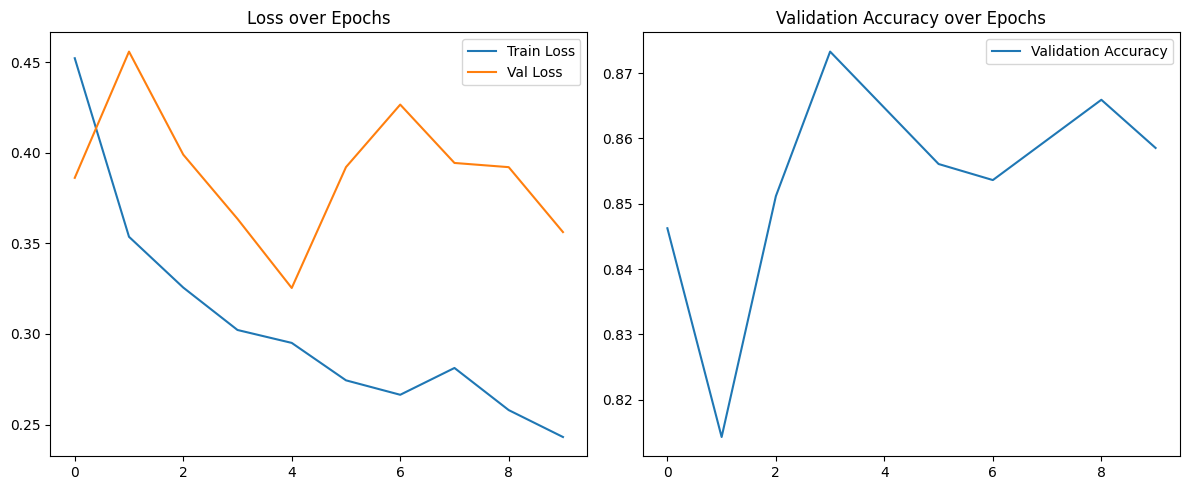


Classification Report:

              precision    recall  f1-score   support

        blur       0.90      0.78      0.84       185
       sharp       0.84      0.92      0.88       221

    accuracy                           0.86       406
   macro avg       0.87      0.85      0.86       406
weighted avg       0.86      0.86      0.86       406



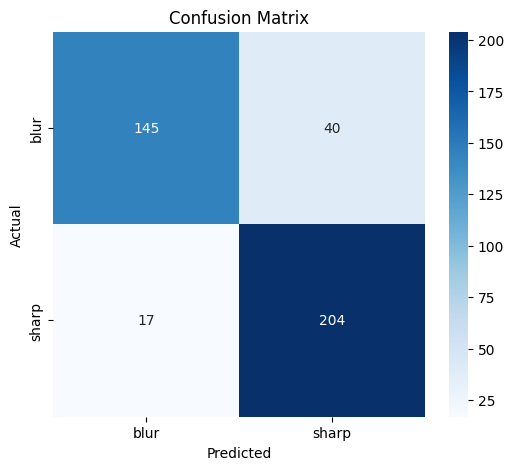

In [3]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

data_dir = "/kaggle/working/blurdetection-1"

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

train_data = datasets.ImageFolder(os.path.join(data_dir, 'train'), transform=transform)
val_data = datasets.ImageFolder(os.path.join(data_dir, 'valid'), transform=transform)
test_data = datasets.ImageFolder(os.path.join(data_dir, 'test'), transform=transform)

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32, shuffle=False)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

print(f"Classes: {train_data.classes}")

model = models.resnet50(pretrained=True)
model.fc = nn.Sequential(
    nn.Linear(model.fc.in_features, 128),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(128, 2)
)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

def train_model(model, train_loader, val_loader, criterion, optimizer, epochs=10):
    train_losses, val_losses, val_accs = [], [], []

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        train_losses.append(running_loss / len(train_loader))

        model.eval()
        correct, total, val_loss = 0, 0, 0.0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                correct += (predicted == labels).sum().item()
                total += labels.size(0)

        val_losses.append(val_loss / len(val_loader))
        val_accs.append(correct / total)

        print(f"Epoch {epoch+1}/{epochs} | Train Loss: {train_losses[-1]:.4f} | Val Loss: {val_losses[-1]:.4f} | Val Acc: {val_accs[-1]*100:.2f}%")

    return train_losses, val_losses, val_accs

train_losses, val_losses, val_accs = train_model(model, train_loader, val_loader, criterion, optimizer, epochs=10)

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.title('Loss over Epochs')
plt.legend()

plt.subplot(1,2,2)
plt.plot(val_accs, label='Validation Accuracy')
plt.title('Validation Accuracy over Epochs')
plt.legend()

plt.tight_layout()
plt.show()

model.eval()
y_true, y_pred = [], []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

print("\nClassification Report:\n")
print(classification_report(y_true, y_pred, target_names=train_data.classes))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=train_data.classes, yticklabels=train_data.classes)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


In [5]:
model_path = "/kaggle/working/best_resnet50_blur_model.pth"
torch.save(model.state_dict(), model_path)
print(f"Model saved to: {model_path}")

Model saved to: /kaggle/working/best_resnet50_blur_model.pth


Using device: cuda


model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Classes: ['blur', 'sharp']


Epoch 1/10 - Training: 100%|██████████| 89/89 [02:00<00:00,  1.35s/it]


Epoch 1/10 | Train Loss: 0.4389 | Val Loss: 0.2890 | Val Acc: 88.56%


Epoch 2/10 - Training: 100%|██████████| 89/89 [01:59<00:00,  1.35s/it]


Epoch 2/10 | Train Loss: 0.2505 | Val Loss: 0.3288 | Val Acc: 87.70%


Epoch 3/10 - Training: 100%|██████████| 89/89 [01:59<00:00,  1.34s/it]


Epoch 3/10 | Train Loss: 0.1342 | Val Loss: 0.4167 | Val Acc: 85.73%


Epoch 4/10 - Training: 100%|██████████| 89/89 [01:59<00:00,  1.35s/it]


Epoch 4/10 | Train Loss: 0.1271 | Val Loss: 0.5724 | Val Acc: 79.21%


Epoch 5/10 - Training: 100%|██████████| 89/89 [01:59<00:00,  1.34s/it]


Epoch 5/10 | Train Loss: 0.0965 | Val Loss: 0.5998 | Val Acc: 85.49%


Epoch 6/10 - Training: 100%|██████████| 89/89 [01:59<00:00,  1.34s/it]


Epoch 6/10 | Train Loss: 0.0154 | Val Loss: 0.4805 | Val Acc: 87.45%


Epoch 7/10 - Training: 100%|██████████| 89/89 [01:59<00:00,  1.34s/it]


Epoch 7/10 | Train Loss: 0.0022 | Val Loss: 0.5297 | Val Acc: 87.70%


Epoch 8/10 - Training: 100%|██████████| 89/89 [01:59<00:00,  1.35s/it]


Epoch 8/10 | Train Loss: 0.0011 | Val Loss: 0.5728 | Val Acc: 87.82%


Epoch 9/10 - Training: 100%|██████████| 89/89 [01:59<00:00,  1.34s/it]


Epoch 9/10 | Train Loss: 0.0006 | Val Loss: 0.6109 | Val Acc: 87.95%


Epoch 10/10 - Training: 100%|██████████| 89/89 [01:59<00:00,  1.34s/it]


Epoch 10/10 | Train Loss: 0.0004 | Val Loss: 0.6431 | Val Acc: 87.95%


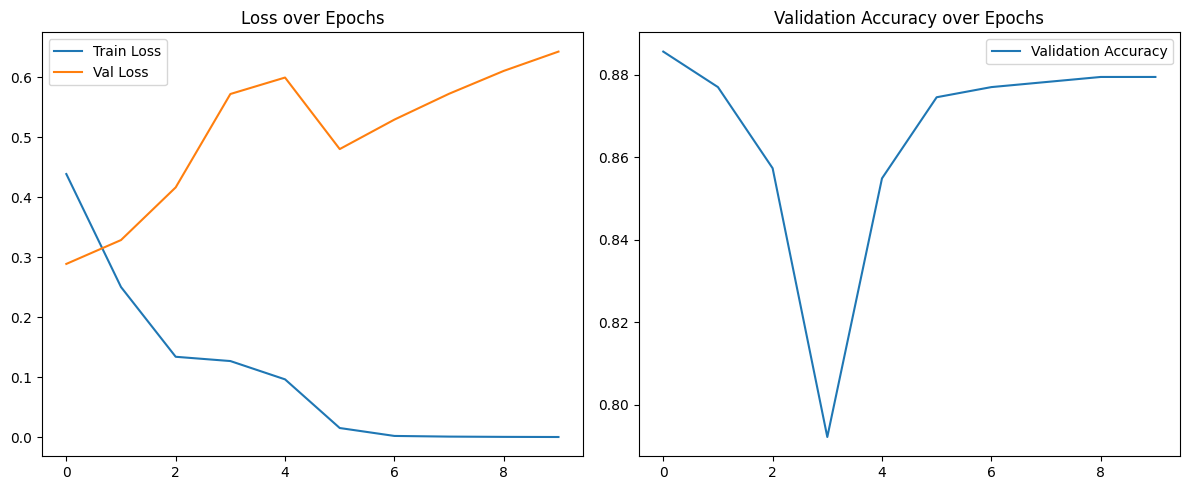


Classification Report:

              precision    recall  f1-score   support

        blur       0.89      0.89      0.89       185
       sharp       0.91      0.91      0.91       221

    accuracy                           0.90       406
   macro avg       0.90      0.90      0.90       406
weighted avg       0.90      0.90      0.90       406



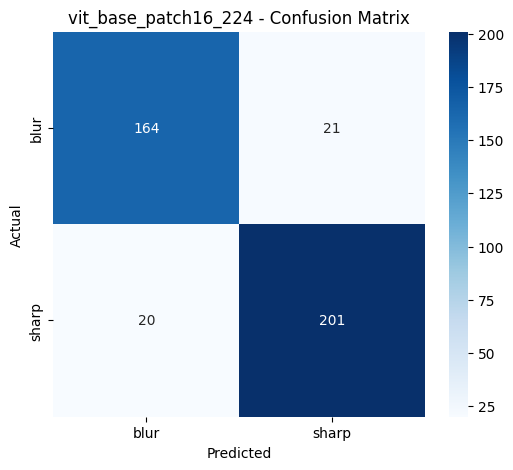

In [6]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from tqdm import tqdm
import timm
from timm.data import resolve_data_config
from timm.data.transforms_factory import create_transform

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

data_dir = "/kaggle/working/blurdetection-1"

def get_model(model_name="vit_base_patch16_224", pretrained=True):
    model = timm.create_model(model_name, pretrained=pretrained, num_classes=2)
    return model.to(device)

def get_transform(model_name):
    model = timm.create_model(model_name, pretrained=True)
    config = resolve_data_config({}, model=model)
    transform = create_transform(**config)
    return transform

def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler=None, epochs=10):
    train_losses, val_losses, val_accs = [], [], []

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs} - Training"):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        train_losses.append(running_loss / len(train_loader))

        model.eval()
        correct, total, val_loss = 0, 0, 0.0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                correct += (predicted == labels).sum().item()
                total += labels.size(0)

        val_losses.append(val_loss / len(val_loader))
        val_accs.append(correct / total)

        print(f"Epoch {epoch+1}/{epochs} | Train Loss: {train_losses[-1]:.4f} | Val Loss: {val_losses[-1]:.4f} | Val Acc: {val_accs[-1]*100:.2f}%")

        if scheduler:
            scheduler.step()

    return train_losses, val_losses, val_accs

model_name = "vit_base_patch16_224"
transform = get_transform(model_name)

train_data = datasets.ImageFolder(os.path.join(data_dir, 'train'), transform=transform)
val_data   = datasets.ImageFolder(os.path.join(data_dir, 'valid'), transform=transform)
test_data  = datasets.ImageFolder(os.path.join(data_dir, 'test'), transform=transform)

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_data, batch_size=32, shuffle=False)
test_loader  = DataLoader(test_data, batch_size=32, shuffle=False)

print(f"Classes: {train_data.classes}")

model = get_model(model_name)
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

train_losses, val_losses, val_accs = train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, epochs=10)

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.title('Loss over Epochs')
plt.legend()

plt.subplot(1,2,2)
plt.plot(val_accs, label='Validation Accuracy')
plt.title('Validation Accuracy over Epochs')
plt.legend()
plt.tight_layout()
plt.show()

model.eval()
y_true, y_pred = [], []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

print("\nClassification Report:\n")
print(classification_report(y_true, y_pred, target_names=train_data.classes))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=train_data.classes, yticklabels=train_data.classes)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f'{model_name} - Confusion Matrix')
plt.show()

In [8]:
model_path = "/kaggle/working/best_ViT_blur_model.pth"
torch.save(model.state_dict(), model_path)
print(f"Model saved to: {model_path}")

Model saved to: /kaggle/working/best_ViT_blur_model.pth
